In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wetter/wetter2019.csv
/kaggle/input/db-regio/regular_travel_test.csv
/kaggle/input/db-regio/regular_travel.csv


# Read the data and convert the problem to classification

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


regular_travel = pd.read_csv('//kaggle/input/db-regio/regular_travel.csv', parse_dates=['date'])

# first we remove the dummy test set rows
regular_travel_train = regular_travel.dropna(subset = ['Passengers'])
#bining of the target 
y = np.digitize(regular_travel_train.Passengers, bins=(1, 2, 3))
regular_travel_train["Passengers_bined"] = y
print(regular_travel.shape)
#merge thhe hole data
regular_travel = regular_travel.merge(regular_travel_train[["date", "hour", "EZone", "Passengers_bined"]], on=["date", "hour", "EZone"], how="left")
print(regular_travel.shape)

(420000, 4)
(420000, 5)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


In [3]:
regular_travel_train.shape

(310800, 5)

In [4]:
regular_travel_train.reset_index(inplace=True,drop=True)
regular_travel_train

,date,EZone,hour,Passengers,Passengers_bined
0,2019-01-01,"15964 - Salzweg, Außenstelle LRA",0,0.0,0
1,2019-01-01,"15964 - Salzweg, Außenstelle LRA",1,0.0,0
2,2019-01-01,"15964 - Salzweg, Außenstelle LRA",2,0.0,0
3,2019-01-01,"15964 - Salzweg, Außenstelle LRA",3,0.0,0
4,2019-01-01,"15964 - Salzweg, Außenstelle LRA",4,0.0,0
...,...,...,...,...,...
310795,2019-12-09,"9750 - Passau, Reisebüro Niedermayer",19,0.0,0
310796,2019-12-09,"9750 - Passau, Reisebüro Niedermayer",20,0.0,0
310797,2019-12-09,"9750 - Passau, Reisebüro Niedermayer",21,0.0,0
310798,2019-12-09,"9750 - Passau, Reisebüro Niedermayer",22,0.0,0


In [5]:
#Read test data
regular_travel_test=pd.read_csv('/kaggle/input/db-regio/regular_travel_test.csv',parse_dates=['date'])
regular_travel_test['Passengers_bined'] = np.digitize(regular_travel_test.Passengers, bins=(1, 2, 3))

In [6]:
#Extract train and test data of each bus stop and put them in dictionaries
#we will use the 'hour' feature and the passengers number in this notebook for the predection
unique_ezones = regular_travel_train['EZone'].unique().tolist()
dfs = {}
test_dfs = {}
for idx, col in enumerate(unique_ezones):
    dfs[f"df_{idx}"] = pd.DataFrame(regular_travel_train[regular_travel_train['EZone'] == col][['Passengers_bined','hour']])
    test_dfs[f"test_df_{idx}"] = pd.DataFrame(regular_travel_test[regular_travel_test['EZone'] == col][['Passengers_bined','hour']])
# print(dfs)
# df=regular_travel_train['Passengers_bined']
# df=pd.DataFrame(df) 

In [7]:
#size(train_data(bus_stop))=62016
dfs['df_1']

,Passengers_bined,hour
24,0,0
25,0,1
26,0,2
27,0,3
28,0,4
...,...,...
309643,1,19
309644,0,20
309645,0,21
309646,0,22


In [8]:
#size(test_data(bus_stop))=2184
test_dfs[f"test_df_{1}"].shape

(2184, 2)

**Preparing data for LSTM**

In [9]:
#we will use the previous 24 hours to predict the number of passengers of the 25th hour
#we will create 24 lags(series)for each 3 weeks of the training and 1 week of predictions for each bus stop
#and then store the new train and test datasets after creting those lags
num_lags=24
new_df = {}
new_test_df = {}
for i in range(len(unique_ezones)):
    df_total = None
    df_test_total = None
    for j in range(1, num_lags + 1):
        df = dfs[f"df_{i}"]
        df_test = test_dfs[f"test_df_{i}"]
        df_year = None
        df_test_year = None
        for k in range(12):            
            df_month = df.iloc[k*504:(k+1)*504, :]
            df_month.insert(loc=2,column=f't-{j}',value=df_month.iloc[:,0].shift(periods=j))
            df_month.insert(loc=2,column=f'hour-{j}',value=df_month.iloc[:,1].shift(periods=j))
            if (k == 0):
                df_year = df_month
            else:
                df_year = pd.concat([df_year, df_month], ignore_index=True, sort=False)
            
            
            df_test_month = df_test.iloc[k*168:(k+1)*168, :]
            df_test_month.insert(loc=2,column=f't-{j}',value=df_test_month.iloc[:,0].shift(periods=j))
            df_test_month.insert(loc=2,column=f'hour-{j}',value=df_test_month.iloc[:,1].shift(periods=j))
            if (k == 0):
                df_test_year = df_test_month
            else:
                df_test_year = pd.concat([df_test_year, df_test_month], ignore_index=True, sort=False)
                
                
        if (j == 1):
            df_total = df_year
            df_test_total = df_test_year
            
        else:
            df_total = pd.concat([df_total, df_year[[f't-{j}',f'hour-{j}']]], axis=1)
            df_test_total = pd.concat([df_test_total, df_test_year[[f't-{j}',f'hour-{j}']]], axis=1)
        
    new_df[f"df_{i}"] = df_total
    new_test_df[f"test_df_{i}"] = df_test_total
#         print(df_month.head())
#             dfs[f"df_{i}"].iloc[k:k+504, :] = df_month
            
            
#             df.iloc[k:k+504, :] = dfs[f"df_{i}"]
#             dfs[f"df_{i}"].insert(loc=1,column=f't-{j}',value=dfs[f"df_{i}"].iloc[:,0].shift(periods=j))
        
#             dfs[f"df_{i}"].dropna(inplace=True)

In [10]:
#Shape(test_df_busstop)=168*12 because we will use 12weeks for testing and 12*3 weeks for training
new_test_df[f"test_df_{1}"].shape

(2016, 50)

In [11]:
#drop Naan values created after the lags
for i in range(len(unique_ezones)):
    new_df[f"df_{i}"].dropna(inplace=True)
    new_test_df[f"test_df_{i}"].dropna(inplace=True)

In [12]:
#shape(train_df(bus_stop))=12*3*7*24-12*24=5760
new_df['df_0']

,Passengers_bined,hour,hour-1,t-1,t-2,hour-2,t-3,hour-3,t-4,hour-4,...,t-20,hour-20,t-21,hour-21,t-22,hour-22,t-23,hour-23,t-24,hour-24
24,0,0,23.0,0.0,0.0,22.0,0.0,21.0,0.0,20.0,...,0.0,4.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0
25,0,1,0.0,0.0,0.0,23.0,0.0,22.0,0.0,21.0,...,0.0,5.0,0.0,4.0,0.0,3.0,0.0,2.0,0.0,1.0
26,0,2,1.0,0.0,0.0,0.0,0.0,23.0,0.0,22.0,...,0.0,6.0,0.0,5.0,0.0,4.0,0.0,3.0,0.0,2.0
27,0,3,2.0,0.0,0.0,1.0,0.0,0.0,0.0,23.0,...,0.0,7.0,0.0,6.0,0.0,5.0,0.0,4.0,0.0,3.0
28,0,4,3.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,8.0,0.0,7.0,0.0,6.0,0.0,5.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043,0,19,18.0,0.0,0.0,17.0,0.0,16.0,0.0,15.0,...,0.0,23.0,0.0,22.0,0.0,21.0,0.0,20.0,0.0,19.0
6044,1,20,19.0,0.0,0.0,18.0,0.0,17.0,0.0,16.0,...,0.0,0.0,0.0,23.0,0.0,22.0,0.0,21.0,0.0,20.0
6045,0,21,20.0,1.0,0.0,19.0,0.0,18.0,0.0,17.0,...,0.0,1.0,0.0,0.0,0.0,23.0,0.0,22.0,0.0,21.0
6046,0,22,21.0,0.0,1.0,20.0,0.0,19.0,0.0,18.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,23.0,0.0,22.0


**OnehotEncoding of the target**

In [13]:
classes = [0, 1, 2, 3]
classes

[0, 1, 2, 3]

In [14]:
for j in range(len(unique_ezones)):
    for i in classes:
        new_df[f"df_{j}"]['class_'+str(i)] = new_df[f"df_{j}"]['Passengers_bined'] == i
        new_df[f"df_{j}"]['class_'+str(i)] = new_df[f"df_{j}"]['class_'+str(i)].astype(int)
        
        new_test_df[f"test_df_{j}"]['class_'+str(i)] = new_test_df[f"test_df_{j}"]['Passengers_bined'] == i
        new_test_df[f"test_df_{j}"]['class_'+str(i)] = new_test_df[f"test_df_{j}"]['class_'+str(i)].astype(int)

In [15]:
#new_shape(5760x54)
new_df["df_49"]

,Passengers_bined,hour,hour-1,t-1,t-2,hour-2,t-3,hour-3,t-4,hour-4,...,t-22,hour-22,t-23,hour-23,t-24,hour-24,class_0,class_1,class_2,class_3
24,0,0,23.0,0.0,0.0,22.0,0.0,21.0,0.0,20.0,...,0.0,2.0,0.0,1.0,0.0,0.0,1,0,0,0
25,0,1,0.0,0.0,0.0,23.0,0.0,22.0,0.0,21.0,...,0.0,3.0,0.0,2.0,0.0,1.0,1,0,0,0
26,0,2,1.0,0.0,0.0,0.0,0.0,23.0,0.0,22.0,...,0.0,4.0,0.0,3.0,0.0,2.0,1,0,0,0
27,0,3,2.0,0.0,0.0,1.0,0.0,0.0,0.0,23.0,...,0.0,5.0,0.0,4.0,0.0,3.0,1,0,0,0
28,0,4,3.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,6.0,0.0,5.0,0.0,4.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043,2,19,18.0,3.0,3.0,17.0,0.0,16.0,3.0,15.0,...,0.0,21.0,0.0,20.0,0.0,19.0,0,0,1,0
6044,0,20,19.0,2.0,3.0,18.0,3.0,17.0,0.0,16.0,...,0.0,22.0,0.0,21.0,0.0,20.0,1,0,0,0
6045,0,21,20.0,0.0,2.0,19.0,3.0,18.0,3.0,17.0,...,0.0,23.0,0.0,22.0,0.0,21.0,1,0,0,0
6046,0,22,21.0,0.0,0.0,20.0,2.0,19.0,3.0,18.0,...,0.0,0.0,0.0,23.0,0.0,22.0,1,0,0,0


In [16]:
#extract the target from the train and test datasets
y_trains = {}
y_tests = {}
for j in range(len(unique_ezones)):
    y_trains[f'y_train_{j}'] = new_df[f"df_{j}"][['class_0','class_1','class_2','class_3']].to_numpy()
    y_tests[f'y_test_{j}'] = new_test_df[f"test_df_{j}"][['class_0','class_1','class_2','class_3']].to_numpy()
 #convert the columns to int type   
    for feature in new_df[f"df_{j}"].columns: 
        new_df[f"df_{j}"][feature] = new_df[f"df_{j}"][feature].astype(int)
        new_test_df[f"test_df_{j}"][feature] = new_test_df[f"test_df_{j}"][feature].astype(int)
        

In [17]:
new_df["df_49"]

,Passengers_bined,hour,hour-1,t-1,t-2,hour-2,t-3,hour-3,t-4,hour-4,...,t-22,hour-22,t-23,hour-23,t-24,hour-24,class_0,class_1,class_2,class_3
24,0,0,23,0,0,22,0,21,0,20,...,0,2,0,1,0,0,1,0,0,0
25,0,1,0,0,0,23,0,22,0,21,...,0,3,0,2,0,1,1,0,0,0
26,0,2,1,0,0,0,0,23,0,22,...,0,4,0,3,0,2,1,0,0,0
27,0,3,2,0,0,1,0,0,0,23,...,0,5,0,4,0,3,1,0,0,0
28,0,4,3,0,0,2,0,1,0,0,...,0,6,0,5,0,4,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043,2,19,18,3,3,17,0,16,3,15,...,0,21,0,20,0,19,0,0,1,0
6044,0,20,19,2,3,18,3,17,0,16,...,0,22,0,21,0,20,1,0,0,0
6045,0,21,20,0,2,19,3,18,3,17,...,0,23,0,22,0,21,1,0,0,0
6046,0,22,21,0,0,20,2,19,3,18,...,0,0,0,23,0,22,1,0,0,0


In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
#Prepare the training and testing data for LSTM to be 3D dimentional(n_samples,n_time_steps,n_features)
#Scale the data to prevent overfitting
x_trains = {}
x_tests = {}
for j in range(len(unique_ezones)):
    x_trains[f'x_train_{j}'] = new_df[f"df_{j}"].drop(columns=['Passengers_bined', 'class_0', 'class_1', 'class_2', 'class_3']).to_numpy()
#     x_trains[f'x_train_{j}'] = x_trains[f'x_train_{j}'].reshape(x_trains[f'x_train_{j}'].shape[0], x_trains[f'x_train_{j}'].shape[1],1)
    
    
    hours_columns = new_df[f"df_{j}"][["hour-1", "hour-2", "hour-3", "hour-4", "hour-5", "hour-6", "hour-7",
                                "hour-8", "hour-9", "hour-10", "hour-11", "hour-12", "hour-13",
                                "hour-14", "hour-15", "hour-16", "hour-17", "hour-18", "hour-19",
                                "hour-20", "hour-21", "hour-22", "hour-23", "hour-24"]].to_numpy()
    scaler1=MinMaxScaler()
    hours_columns=scaler1.fit_transform(hours_columns)
    passengers_columns = new_df[f"df_{j}"][["t-1", "t-2", "t-3", "t-4", "t-5", "t-6", "t-7",
                                    "t-8", "t-9", "t-10", "t-11", "t-12", "t-13",
                                    "t-14", "t-15", "t-16", "t-17", "t-18", "t-19",
                                    "t-20", "t-21", "t-22", "t-23", "t-24"]].to_numpy()
    scaler2=MinMaxScaler()
    passengers_columns=scaler2.fit_transform(passengers_columns)
    x_trains[f'x_train_{j}'] = np.stack([hours_columns, passengers_columns], axis=2)
    
    
    
    x_tests[f'x_test_{j}'] = new_test_df[f"test_df_{j}"].drop(columns=['Passengers_bined', 'class_0', 'class_1', 'class_2', 'class_3']).to_numpy()
    hours_columns_test = new_test_df[f"test_df_{j}"][["hour-1", "hour-2", "hour-3", "hour-4", "hour-5", "hour-6", "hour-7",
                                "hour-8", "hour-9", "hour-10", "hour-11", "hour-12", "hour-13",
                                "hour-14", "hour-15", "hour-16", "hour-17", "hour-18", "hour-19",
                                "hour-20", "hour-21", "hour-22", "hour-23", "hour-24"]].to_numpy()
    hours_columns_test=scaler1.fit_transform(hours_columns_test)
    passengers_columns_test = new_test_df[f"test_df_{j}"][["t-1", "t-2", "t-3", "t-4", "t-5", "t-6", "t-7",
                                    "t-8", "t-9", "t-10", "t-11", "t-12", "t-13",
                                    "t-14", "t-15", "t-16", "t-17", "t-18", "t-19",
                                    "t-20", "t-21", "t-22", "t-23", "t-24"]].to_numpy()
    passengers_columns_test=scaler2.fit_transform(passengers_columns_test)
    x_tests[f'x_test_{j}'] = np.stack([hours_columns_test, passengers_columns_test], axis=2)
    
    
    
#     x_tests[f'x_test_{j}'] = x_tests[f'x_test_{j}'].reshape(x_tests[f'x_test_{j}'].shape[0], x_tests[f'x_test_{j}'].shape[1],1)

In [20]:
#shape=(n_samples,n_time_steps,n_features)=(5760,24,2)
x_trains[f'x_train_{49}'].shape

(5760, 24, 2)

In [21]:
y_trains["y_train_0"].shape

(5760, 4)

In [32]:
from keras.models import Sequential,Functional
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense,BatchNormalization
from keras import metrics
import keras
import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tensorflow.keras.optimizers import Adam

In [23]:
from sklearn.metrics import f1_score

In [37]:
optimizer=Adam(learning_rate=0.001)

**Example: training LSTM on the first 3 weeks for one bus stop**

In [39]:
y=y_trains[f'y_train_{49}'][480:960]
X=x_trains[f'x_train_{49}'][480:960]
y_test=y_tests[f'y_test_{49}'][144:288]
x_test=x_tests[f'x_test_{49}'][144:288]

In [28]:
#Ajust class_weights using training data
decoded_y=np.argmax(y,axis=1)
class_0=np.count_nonzero(decoded_y==0)
class_1=np.count_nonzero(decoded_y==1)
class_2=np.count_nonzero(decoded_y==2)
class_3=np.count_nonzero(decoded_y==3)
S=class_0+class_1+class_2+class_3
class_weights={0:S/(class_0*4),1:S/(class_1*4),2:S/(class_2*4),3:S/(class_3*4)}
print(class_weights)

{0: 0.3333333333333333, 1: 2.2641509433962264, 2: 4.137931034482759, 3: 3.1578947368421053}


In [48]:
!pip install tensorflow-addons

In [26]:
import tensorflow_addons as tfa

Epoch 1/50
39/39 [==============================] - 3s 52ms/step - loss: 1.3313 - f1_score: 0.2448 - val_loss: 1.1669 - val_f1_score: 0.2303
Epoch 2/50
39/39 [==============================] - 2s 46ms/step - loss: 1.1950 - f1_score: 0.2267 - val_loss: 1.0321 - val_f1_score: 0.2303
Epoch 3/50
39/39 [==============================] - 2s 52ms/step - loss: 1.1248 - f1_score: 0.2192 - val_loss: 0.9390 - val_f1_score: 0.2303
Epoch 4/50
39/39 [==============================] - 2s 44ms/step - loss: 1.0698 - f1_score: 0.2300 - val_loss: 0.8736 - val_f1_score: 0.2303
Epoch 5/50
39/39 [==============================] - 2s 44ms/step - loss: 1.0247 - f1_score: 0.2379 - val_loss: 0.8159 - val_f1_score: 0.2303
Epoch 6/50
39/39 [==============================] - 2s 62ms/step - loss: 0.9946 - f1_score: 0.2598 - val_loss: 0.7745 - val_f1_score: 0.2303
Epoch 7/50
39/39 [==============================] - 2s 45ms/step - loss: 0.9676 - f1_score: 0.2606 - val_loss: 0.7391 - val_f1_score: 0.2303
Epoch 8/50
39

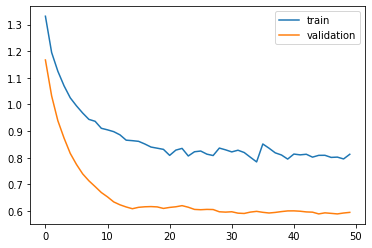

In [40]:
estimator=Sequential()
estimator.add(LSTM(units=1,activation='relu',input_shape=(24,2)))
estimator.add(BatchNormalization())
#estimator.add(Dropout(0.5))
#estimator.add(LSTM(4, activation='relu',,return_sequences=True))
#estimator.add(Dropout(0.1))
#estimator.add(LSTM(10, activation='relu'))
#estimator.add(Dropout(0.2))
estimator.add(Dense(units=4,activation='softmax'))
estimator.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=[tfa.metrics.F1Score(average='macro',num_classes=4)])
history=estimator.fit(X,y,batch_size=10,epochs=50,validation_split=0.2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
#plt.plot(history.history['f1_score'],label='f1_score')
plt.legend()
plt.show()
#pred = model.predict(x_tests[f'x_test_{49}'][0:144])

# Create a model for each bus stop 

In [55]:
#use incremental training to improve the model performance by using 
#the training data of the previous months to retrain the model
stations_f1_scores={}
predictions = pd.DataFrame()
for j in range(len(unique_ezones)):
    model=Sequential()
    model.add(LSTM(units=1,activation='relu',input_shape=(24,2)))
    model.add(Dense(units=4,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=[tfa.metrics.F1Score(average='macro',num_classes=4)])
    f1_sc=0
    for k in range(12):
        model.fit(x_trains[f'x_train_{j}'][k*480:(k+1)*480],y_trains[f'y_train_{j}'][0:(k+1)*480],batch_size=10,epochs=10,validation_split=0.3)
        pred = model.predict(x_tests[f'x_test_{j}'][k*144:(k+1)*144,:,:])
        decoded_pred=np.argmax(pred,axis=1)
        y_true=np.argmax(y_tests[f'y_test_{j}'][k*144:(k+1)*144,:],axis=1)
        f1_sc=f1_sc+sklearn.metrics.f1_score(decoded_pred,y_true,average='macro')
        #print(sklearn.metrics.f1_score(decoded_pred,y_true,average='macro'))
    avg_f1_score=f1_sc/12
    stations_f1_scores[j]=avg_f1_score
    model.save(f'model_{j}.h5')

Epoch 1/10
34/34 [==============================] - 3s 54ms/step - loss: 1.3176 - f1_score: 0.2210 - val_loss: 1.1886 - val_f1_score: 0.2262
Epoch 2/10
34/34 [==============================] - 2s 45ms/step - loss: 1.1024 - f1_score: 0.2303 - val_loss: 1.0536 - val_f1_score: 0.2262
Epoch 3/10
34/34 [==============================] - 2s 46ms/step - loss: 0.9902 - f1_score: 0.2303 - val_loss: 0.9702 - val_f1_score: 0.2262
Epoch 4/10
34/34 [==============================] - 2s 54ms/step - loss: 0.9146 - f1_score: 0.2303 - val_loss: 0.9118 - val_f1_score: 0.2262
Epoch 5/10
34/34 [==============================] - 2s 47ms/step - loss: 0.8590 - f1_score: 0.2303 - val_loss: 0.8658 - val_f1_score: 0.2262
Epoch 6/10
34/34 [==============================] - 1s 44ms/step - loss: 0.8150 - f1_score: 0.2303 - val_loss: 0.8306 - val_f1_score: 0.2262
Epoch 7/10
34/34 [==============================] - 2s 45ms/step - loss: 0.7796 - f1_score: 0.2303 - val_loss: 0.8027 - val_f1_score: 0.2262
Epoch 8/10
34

KeyboardInterrupt: 

**Predictions**

**Example of prediction**

**Evaluation of the predictions**

# Recursive Forecust

we will use recursive forecast to predict more than one step in the future

In [ ]:
def recursive_forecast(model, data, window_size, horizon):
    forecast = []
    for i in range(horizon):
        # Use the last window_size elements of data as input
        input_data = data[-window_size:, 0]
        # Reshape the input data to the shape expected by the model
        input_data = input_data.reshape((1, window_size, 1))
        # Get the next forecast
        next_forecast = model.predict(input_data)
        # Append the forecast to the data
        arg_max=np.argmax(next_forecast[0],axis=0)
        data = np.append(data, arg_max)
        data=data.reshape(data.shape[0],1)
        forecast.append(arg_max)
    return forecast

In [ ]:
# Use the recursive function to make a forecast for 2 hours in the future
sample_predict=recursive_forecast(estimator, data, 24,2)

In [ ]:
sample_predict